In [1]:
import Data_loader_module 
import Build_model
from transformers import DetrImageProcessor
import matplotlib.pyplot as plt
import os
import supervision as sv 
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
import torch
from pytorch_lightning import Trainer

/home/nguyen-van-anh/anaconda3/envs/tf_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
TRAIN_DIR = "train"
VAL_DIR = "valid"
TEST_DIR = "test"

image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [3]:
TRAIN_DATASET = Data_loader_module.CocoDetection(image_dir=TRAIN_DIR, image_processor=image_processor, train=True)
VAL_DATASET = Data_loader_module.CocoDetection(image_dir=VAL_DIR, image_processor=image_processor, train=False)
TEST_DATASET = Data_loader_module.CocoDetection(image_dir=TEST_DIR, image_processor=image_processor, train=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
print(len(TRAIN_DATASET))
print(len(VAL_DATASET))
print(len(TEST_DATASET))

326
88
44


In [5]:
TRAIN_DATASET

Dataset CocoDetection
    Number of datapoints: 326
    Root location: train

In [6]:
image_ids = TRAIN_DATASET.coco.getImgIds()

In [7]:
image_ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [8]:
image = TRAIN_DATASET.coco.loadImgs([0])[0]

In [9]:
image

{'id': 0,
 'license': 1,
 'file_name': '70_jpg.rf.a45b1f9b3f335f0cc7210b9dc2f858cf.jpg',
 'height': 1024,
 'width': 752,
 'date_captured': '2022-08-30T09:40:29+00:00'}

In [10]:
annotations = TRAIN_DATASET.coco.imgToAnns[0]
annotations

[{'id': 0,
  'image_id': 0,
  'category_id': 4,
  'bbox': [242, 211, 125, 175],
  'area': 21875,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 0,
  'category_id': 4,
  'bbox': [297, 502, 144, 147],
  'area': 21168,
  'segmentation': [],
  'iscrowd': 0}]

(np.float64(-0.5), np.float64(751.5), np.float64(1023.5), np.float64(-0.5))

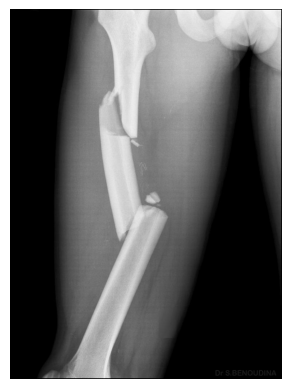

In [11]:
image_path = os.path.join(TRAIN_DIR, image['file_name'])
real_image = Image.open(image_path)
plt.imshow(real_image)
plt.axis("off")

In [12]:
def coco_to_detections(annotations):
    """Convert COCO annotations to supervision detections."""
    xyxy = np.array([[x, y, x + w, y + h] for ann in annotations for x, y, w, h in [ann["bbox"]]])
    class_id = np.array([ann["category_id"] for ann in annotations])
    return sv.Detections(xyxy=xyxy, class_id=class_id)


In [13]:
detections = coco_to_detections(annotations)

In [14]:
detections

Detections(xyxy=array([[242, 211, 367, 386],
       [297, 502, 441, 649]]), mask=None, confidence=None, class_id=array([4, 4]), tracker_id=None, data={}, metadata={})

In [15]:
categories = TRAIN_DATASET.coco.cats
categories

{0: {'id': 0, 'name': 'bone-fracture', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'angle', 'supercategory': 'bone-fracture'},
 2: {'id': 2, 'name': 'fracture', 'supercategory': 'bone-fracture'},
 3: {'id': 3, 'name': 'line', 'supercategory': 'bone-fracture'},
 4: {'id': 4, 'name': 'messed_up_angle', 'supercategory': 'bone-fracture'}}

In [16]:
id2label = {k : v['name'] for k, v in categories.items()}
id2label

{0: 'bone-fracture',
 1: 'angle',
 2: 'fracture',
 3: 'line',
 4: 'messed_up_angle'}

In [17]:
type(detections)

supervision.detection.core.Detections

In [18]:
detections.class_id

array([4, 4])

In [19]:
labels = [id2label[class_id] for class_id in detections.class_id]
labels

['messed_up_angle', 'messed_up_angle']

In [20]:
box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=real_image, detections=detections,)

label_annotator = sv.LabelAnnotator()
frame = label_annotator.annotate(scene=real_image, detections=detections, labels=labels)


(np.float64(-0.5), np.float64(751.5), np.float64(1023.5), np.float64(-0.5))

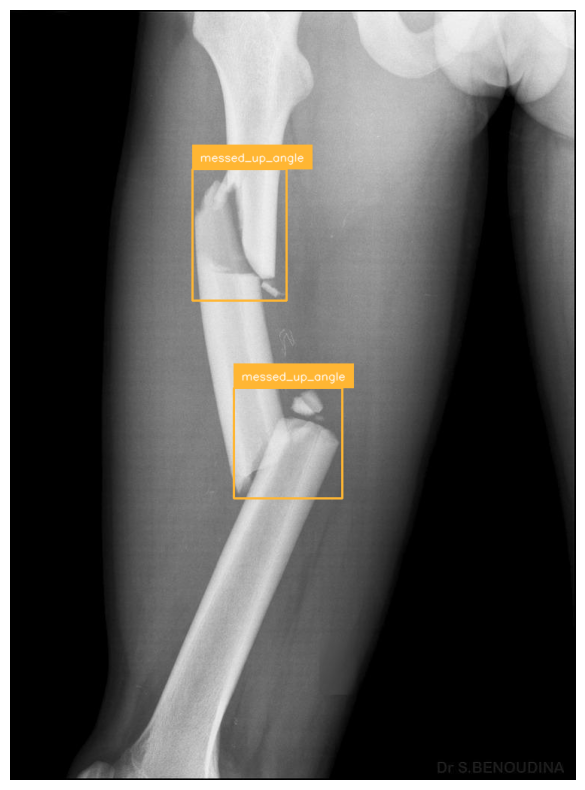

In [21]:
plt.figure(figsize=(16, 10))
plt.imshow(frame)
plt.axis("off")

In [22]:
torch.set_float32_matmul_precision("medium")

In [ ]:
# To preprocess input before passing it to the model
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    encoding = image_processor.pad(pixel_values, return_tensors="pt")


    return {
        "pixel_values": encoding["pixel_values"],
        "pixel_mask": encoding["pixel_mask"],
        "labels": labels
    }

In [26]:
TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET,
                              collate_fn=collate_fn, 
                              batch_size=4,
                              shuffle=True)

VAL_DATALOADER = DataLoader(dataset=VAL_DATASET,
                            collate_fn=collate_fn, 
                            batch_size=4,
                            shuffle=False)

In [27]:
model = Build_model.DeTr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4, idslabel=id2label, TRAIN_DATALOADER=TRAIN_DATALOADER, VAL_DATALOADER=VAL_DATALOADER)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [28]:
log_dir = "log"
MAX_EPOCHS = 200
trainer = Trainer(devices=1,
                  accelerator="gpu",
                  gradient_clip_val=0.1,
                  accumulate_grad_batches=8,
                  log_every_n_steps=1, 
                  max_epochs=MAX_EPOCHS, 
                  default_root_dir=log_dir)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [29]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type                   ┃ Params ┃ Mode ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━┩
│ 0 │ model │ DetrForObjectDetection │ 41.5 M │ eval │     0 │
└───┴───────┴────────────────────────┴────────┴──────┴───────┘

Trainable params: 41.3 M                                                                                           
Non-trainable params: 222 K                                                                                        
Total params: 41.5 M                                                                                               
Total estimated model params size (MB): 166                                                                        
Modules in train mode: 0                                                                                           
Modules in eval mode: 399                                                                                          
Total FLOPs: 0

UserWarning: install "ipywidgets" for Jupyter support

PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing
the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid 
any miscalculations, use `self.log(..., batch_size=batch_size)`.

PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

PossibleUserWarning: Found 399 module(s) in eval mode at the start of training. This may lead to unexpected 
behavior during training. If this is intentional, you can ignore this warning.

OutOfMemoryError: CUDA out of memory. Tried to allocate 136.00 MiB. GPU 0 has a total capacity of 3.69 GiB of which 49.31 MiB is free. Process 3530 has 4.15 MiB memory in use. Including non-PyTorch memory, this process has 3.63 GiB memory in use. Of the allocated memory 3.47 GiB is allocated by PyTorch, and 70.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)